## RBNZ Bank Financial Strength Dashboard data app

The Financail Strength Dashboard is a great iniative of the RBNZ. It allows you to retrieve many data points from NZ banks on a quarterly basis.

The Reserve bank posts a spreadsheet on its web-site, which the scripts below then use for analysis. 

See this post for the grahps it produces: https://capitalissues.co/2018/11/27/updated-nz-capital-ratios/

Below are some code snippets to manage the RBNZ Bank Financial Strength Dashboard data.

### Where to find the data:

Go to: https://bankdashboard.rbnz.govt.nz/summary

Download the Excel file, via the link in the upper right corner of the site.

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
# To clean the series names
def fun(s):
    s = re.sub('\%', ' pct ', s)
    s = re.sub('\(.*\)', '', s)
    s = re.sub('[<>=\*\/]', '', s)
    s = re.sub('\s+', ' ', s)
    return(s)

In [3]:
# Generate a nice dataframe, select a month and year
def dash_data(fn, year, month):
    df = pd.read_excel(fn, sheet_name ='Data', skiprows=range(0,4), index_col=1)
    dfe= pd.read_excel(fn, sheet_name ='Series Definitions' , usecols = 2)[['Series Id', 'Series']]
    dfe['Series'] = dfe['Series'].apply(fun).str.strip()
    dfe['Code'], dfe['Series'] = dfe['Series'].str.split(' ', 1).str
    dfe['Code'] = dfe.Code.str.replace('.' , '')
    df = df.loc[(df['Series Id'].dt.month==month) & (df['Series Id'].dt.year==year)]
    df = df.rename(index=str, columns=dfe.set_index('Series Id')['Series'].to_dict())
    df = df.rename(index=str, columns={'Series Id': 'Date'})
    df.dropna(subset=['Total capital ratio'], inplace=True)  # ignore banks without TCR
    return(df)

In [4]:
# Get the data for September 2018
year, month = 2018, 9
df = dash_data('Bank-Financial-Strength-Dashboard-Data_Sept.xlsx', year, month)
df.head()

,Date,S&P Global,Fitch,Moody's,Total capital ratio,CET1 capital ratio,Tier 1 capital ratio,Buffer ratio,Total capital ratio regulatory minimum,CET1 capital,CET1 deductions,Net CET1,Additional Tier 1 instruments,Total Tier 1 capital,Tier 2 instruments,Total capital,Sovereign quasi-sovereign,Public sector entities,Registered banks,Corporates,Residential mortgages,Problem loans,Equity holdings,All other assets,Commitments & contingent items,CCR for market-related contracts,Credit risk supervisory adj,Credit risk,Market risk,Operational risk,Total RWAs,Total loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,Total loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,Total loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,Total loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,Total loans,Impaired loans,Loans 90 days past due but not impaired,Total non-performing loans,Non-performing loans ratio,Individual provisions,Collective provisions,Share of residential mortgages LVR 80 pct 90 pct,Share of residential mortgages LVR over 90 pct,Return on assets,Return on equity,Net interest margin,Interest income,Interest expense,Net interest income,Gains losses on trading and hedging,Fees and commission income,All other income,Operating expenses,Impaired asset expense,Profit before tax,Tax expense,Profit after tax,Total assets,Cash and bank deposits,Debt securities held,Net loans and advances,Derivatives in an asset position,Repos and all other assets,Total liabilities and equity,Total liabilities,Deposits,Debt securities issued,Repos and other borrowings,Derivatives in a liability position,All other liabilities,Equity,Quarterly average core funding ratio,Quarterly average 1-month mismatch ratio,Quarterly average 1-week mismatch ratio,Top 5 credit exposures to non-bank counterparties CET1,Credit exposures to non-bank counterparties 10 pct of CET1,Top 5 credit exposures to banks CET1,Credit exposures to banks 10 pct of CET1
Institution,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANZ,2018-09-30,AA-,AA-,A1,14.4,11.1,14.4,6.4,8.0,12808.7,3727.2,9081.5,2776.6,11858.0,0.0,11858.0,123.7,343.9,1867.1,36277.5,16955.8,742.2,28.0,12680.8,NaN,NaN,2325.2,71344.2,4776.0,6026.9,82147.0,127057.6,321.0,205.4,526.4,0.4,130.4,381.8,75846.9,34.9,151.0,185.9,0.2,8.0,72.4,3573.9,10.6,23.8,34.4,1.0,6.0,63.5,28821.4,76.3,26.9,103.2,0.4,45.5,91.3,17427.3,153.8,3.4,157.2,0.9,34.9,42.8,1388.0,45.4,0.2,45.6,3.3,35.9,111.8,3.4,1.7,1.3,15.6,2.2,1623.0,825.0,798.0,92.0,163.0,45.0,396.0,-23.0,725.0,204.0,521.0,159011.8,4023.4,14574.6,126466.1,8086.2,5861.4,159011.8,145903.1,104055.3,26590.3,4678.9,8094.9,2483.7,13108.7,89.5,5.1,5.3,51.3,2.0,48.4,3.0
ASB,2018-09-30,AA-,AA-,A1,13.9,10.7,12.5,5.9,8.0,6403.6,350.8,6052.8,1000.0,7052.8,829.6,7882.3,224.0,19.2,1174.8,17966.2,17580.8,2665.5,1.4,9187.9,NaN,NaN,NaN,48819.8,3414.1,4375.0,56608.8,83983.1,430.5,93.1,523.6,0.6,44.6,320.6,54582.6,25.4,58.9,84.3,0.2,5.5,61.0,2004.7,0.8,11.8,12.6,0.6,0.0,80.3,16086.3,35.4,20.4,55.8,0.3,15.7,88.6,10618.2,368.8,2.0,370.8,3.5,22.8,72.1,691.2,NaN,0.0,0.0,0.0,0.5,18.7,5.4,2.2,1.3,15.8,2.3,1091.0,559.1,531.9,20.9,129.8,0.0,232.7,9.2,440.7,123.6,317.1,95759.5,2223.7,5791.3,83769.9,1857.5,2117.0,95759.4,87776.3,61460.8,23176.6,1763.5,659.0,716.5,7983.1,86.7,6.0,5.7,16.5,0.0,55.7,3.0
BNZ,2018-09-30,AA-,AA-,A1,13.6,10.6,12.0,5.6,8.0,7376.4,566.3,6810.1,90

In [5]:
# Function to create a table of aggregated data, in LaTex
def dash_table(df, varlist):
    dfw = df[varlist].fillna(0)
    som = dfw[varlist].sum() 
    rwa = som['Total RWAs']
    som_rwa = som/rwa
    som   = som.to_frame(name='summed').join(som_rwa.to_frame(name='ratios'))
    table = som.copy()
    table['Summed values'] = ['{:,.0f}'.format(x) for x in table['summed']]
    table['Ratios'] = ['{:,.2f}'.format(x) for x in table['ratios']*100]
    print(table[['Summed values', 'Ratios']].to_latex())
    return(som, table)

In [6]:
# Create a table of aggregated data, in Latex
varlist = ['Equity', 'CET1 capital', 'CET1 deductions','Net CET1', 'Additional Tier 1 instruments', 'Total Tier 1 capital', 'Tier 2 instruments', 'Total capital', 'Total RWAs']
som, table = dash_table(df, varlist)

\begin{tabular}{lll}
\toprule
{} & Summed values &  Ratios \\
\midrule
Equity                        &        41,363 &   13.97 \\
CET1 capital                  &        39,484 &   13.34 \\
CET1 deductions               &         5,871 &    1.98 \\
Net CET1                      &        33,614 &   11.35 \\
Additional Tier 1 instruments &         6,326 &    2.14 \\
Total Tier 1 capital          &        39,940 &   13.49 \\
Tier 2 instruments            &         3,301 &    1.11 \\
Total capital                 &        43,241 &   14.60 \\
Total RWAs                    &       296,092 &  100.00 \\
\bottomrule
\end{tabular}



In [7]:
# Function to single out the big banks
# thresh -> minimum RWA in $m
def bigbanks(df, thresh):
    dfb = df[['Net CET1', 'Total RWAs']].copy()
    dfb["CET1_ratio"] = dfb['Net CET1'].div(dfb['Total RWAs'])*100
    dfb["Size"] = np.log(dfb['Total RWAs'])
    dfb = dfb.loc[dfb['Total RWAs']>thresh]
    return(dfb)

In [8]:
dfb = bigbanks(df, 50000)
dfb.head()

,Net CET1,Total RWAs,CET1_ratio,Size
Institution,,,,
ANZ,9081.5,82147.0,11.055182,11.316266
ASB,6052.8,56608.8,10.692331,10.943920
BNZ,6810.1,64491.8,10.559637,11.074293
Westpac,6289.9,53820.0,11.686919,10.893400


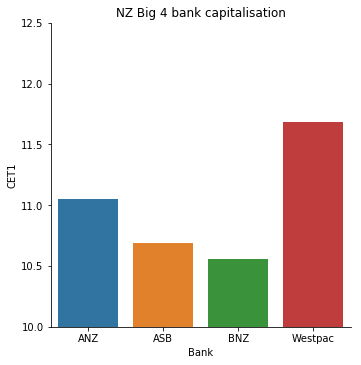

In [9]:
def graph_big_banks(dfb):
    #seq_col_brew = sns.color_palette("Blues_r", 4)
    #sns.set_palette(seq_col_brew)
    ax  = sns.catplot(x = "Institution", y = "CET1_ratio", kind="bar", data = dfb.reset_index())
    nofbanks = len(dfb)
    plt.ylim(10, 12.5)
    plt.title('NZ Big ' + str(nofbanks)+ ' bank capitalisation')
    plt.xlabel('Bank')
    plt.ylabel('CET1')
    plt.show()
graph_big_banks(dfb)

In [10]:
# Function to select all banks
def all_banks(df):
    df = df[['Net CET1', 'Total RWAs']].copy()
    df["CET1_ratio"] = df['Net CET1'].div(df['Total RWAs'])*100
    df["Size"] = np.log(df['Total RWAs'])
    df = df.loc[df.CET1_ratio<30]
    return(df)

In [11]:
# Select all banks for graphs
data = all_banks(df)

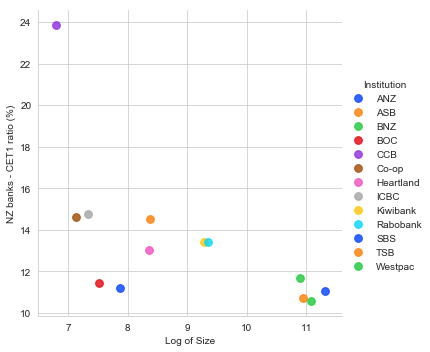

In [12]:
# Plot the banks' capitalisation
def graph_bank_cap(data):
    sns.set_style("whitegrid")
    ax = sns.lmplot(data=data.reset_index(), x="Size", y="CET1_ratio", hue='Institution', palette = 'bright', scatter_kws={"s": 60}, fit_reg=False) #
    ax.set(xlabel='Log of Size', ylabel='NZ banks - CET1 ratio (%)')
    plt.show()
graph_bank_cap(data)

/home/martien/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


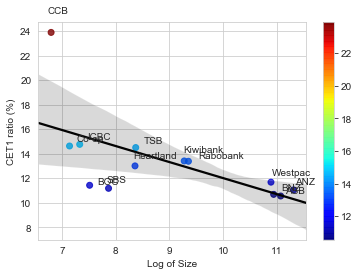

In [13]:
# Another plot of the banks' capitalisation
def graph_size_cap(data):
    offset = 1
    sns.set_style("whitegrid")
    ax = plt.scatter(data["Size"],data["CET1_ratio"], alpha = .8, c = data["CET1_ratio"], cmap = 'jet')
    for label, x, y in zip(data.reset_index()['Institution'], data["Size"], data["CET1_ratio"]):
        plt.annotate(label, xy = (x, y), xytext = (x -10*(offset & 1), y -10 + 5*(offset & 1) ), textcoords = 'offset points')
        offset +=1
    cbar = plt.colorbar()
    sns.regplot(data["Size"],data["CET1_ratio"], data=data, scatter=False, color=".01")
    plt.xlabel('Log of Size')
    plt.ylabel('CET1 ratio (%)')
    plt.show()
graph_size_cap(data)